In [1]:
from sklearn import model_selection 
import pandas as pd
import utils_bmi
import numpy as np
from scipy import interpolate
import os


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split,KFold

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import metrics
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

FileExistsError: [Errno 17] File exists: '/Users/leahbriscoe/Documents/MicroBatch/MicrobiomeDenoising_Plots/WR_AD'

In [2]:
data_folder = "/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc/data/Hispanic_otu"#microbatch_vc/data/AGP_reprocess_k6" #"WR_AD")#

plot_folder = "/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc/plots/Hispanic_otu/" #+ str("AGP_2018_biomotu_k7_feces")# str("WR_AD")
#os.mkdir(plot_folder)
methods = ["raw","bmc","ComBat","ComBat_with_batch2","pca_regress_out_scale_first2","clr_pca_regress_out_no_scale_first2",
           "pca_regress_out_scale_first5","clr_pca_regress_out_no_scale_first5","limma"]#"refactor","refactor_shift1","smartsva"]#["raw","bmc","pca_regress_out_scale_first1","clr_pca_regress_out_scale_first1","clr_pca_regress_out_no_scale_first1"]
data_type = "otu"

methods_dict = utils_bmi.load_data(data_folder,methods,data_type)
#["rel_ab","ComBat_mle","ComBat","percentile_norm","slope_correction","limma","bmc","pca_regress_out"]


raw
bmc
ComBat
ComBat_with_batch2
pca_regress_out_scale_first2
clr_pca_regress_out_no_scale_first2
pca_regress_out_scale_first5
clr_pca_regress_out_no_scale_first5
limma


In [3]:
metadata = pd.read_csv(data_folder + "/metadata.txt",delimiter="\t")

In [4]:
metadata = metadata.loc[methods_dict['raw'].columns]

In [5]:
#metadata['bmi_cor'] = [float('Nan') if i == 'not applicable' or i == 'Not provided' else float(i) for i in list(metadata['bmi_corrected'])]


metadata['bmi_cor'] = [float('Nan') if i == 'not applicable' or i == 'not provided' else float(i) for i in list(metadata['bmi_v2'])]



In [6]:
column_of_interest = 'bmi_cor'#'bmi_corrected'#"diabetes"
#pos_label = 'Healthy'#"Healthy"#'1-2' #'0-0.5'#'Omnivore' # '0-1.5'

In [7]:
names = ["Linear Regression"]

#all_methods_metrics = dict()
#all_methods_means = pd.DataFrame(index = methods, columns= names)
all_methods_stats = dict()

In [8]:
n_repeats = 4
n_splits = 5
for method in methods:
    print(method)
    X = []
    y = []
    
    all_methods_stats[method] = dict()
    X = np.array(methods_dict[method].transpose())
    y = np.array(metadata.loc[methods_dict[method].columns][column_of_interest])
    y = [float("nan") if y_i == "Not provided" else float(y_i) for y_i in y]
    na_mask = pd.isna(y)
    y = np.array(y)
    y = y[~na_mask]
    X = X[~na_mask,:]

    rskf = model_selection.KFold(n_splits=5, random_state=123)
    
    cv_pearson = []
    cv_mse = []
    for train_index, test_index in rskf.split(X, y):
        #print(cv_it)
        X_train, X_test = X[train_index,], X[test_index,]
        y_train, y_test = y[train_index], y[test_index]

        reg = LinearRegression().fit(X_train, y_train)
        pred = reg.predict(X_test)
        cv_pearson.append(np.corrcoef(x=list(y_test),y=list(pred))[0,1])
        cv_mse.append(mean_squared_error(list(y_test),list(pred) ))
     
    
    all_methods_stats[method]['pearson'] = cv_pearson
    all_methods_stats[method]['mse'] = cv_mse
    
      

raw
bmc
ComBat
ComBat_with_batch2
pca_regress_out_scale_first2
clr_pca_regress_out_no_scale_first2
pca_regress_out_scale_first5
clr_pca_regress_out_no_scale_first5
limma


In [9]:
all_methods_stats

{'raw': {'pearson': [0.02271330189249556,
   0.06877960297462221,
   0.05951500199466233,
   0.0012722538804203684,
   0.010568123324695047],
  'mse': [477004379645.9922,
   14036195506854.873,
   783418847999792.4,
   2669.8232632291924,
   6311.1239917189005]},
 'bmc': {'pearson': [-0.004240129907630282,
   0.004608130428744373,
   -0.054362648058771806,
   -0.007532104336279406,
   -0.020027538104672657],
  'mse': [51194068471200.6,
   574314725116981.4,
   10924003998.67621,
   5016.089991677332,
   2887.936198951468]},
 'ComBat': {'pearson': [-0.02158997054338174,
   -0.013028483010081858,
   -0.05484024977560985,
   0.0011391478911168928,
   -0.00017019195339186473],
  'mse': [3509562534277.4844,
   5382460109.158655,
   2433049658889.072,
   3350.2634055483372,
   414.2385621946347]},
 'ComBat_with_batch2': {'pearson': [5.3989282095121555e-05,
   -0.05579470052059682,
   0.07586843900195533,
   0.08939690892696148,
   0.17393044249178938],
  'mse': [631.8486802354298,
   599.780

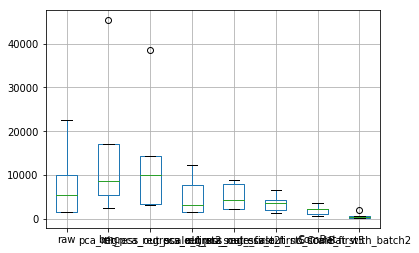

In [12]:
df_mse = pd.DataFrame()
df_mse['raw'] = pd.Series(all_methods_stats['raw']['mse'])
#df_mse['raw'] = pd.Series(all_methods_stats['raw']['mse'])
df_mse['bmc'] = pd.Series(all_methods_stats['bmc']['mse'])
df_mse['pca_regress_out_scale_first2'] = pd.Series(all_methods_stats['pca_regress_out_scale_first2']['mse'])
df_mse['clr_pca_regress_out_no_scale_first2'] = pd.Series(all_methods_stats['clr_pca_regress_out_no_scale_first2']['mse'])
df_mse['pca_regress_out_scale_first5'] = pd.Series(all_methods_stats['pca_regress_out_scale_first5']['mse'])
df_mse['clr_pca_regress_out_no_scale_first5'] = pd.Series(all_methods_stats['clr_pca_regress_out_no_scale_first5']['mse'])

df_mse['ComBat'] = pd.Series(all_methods_stats['ComBat']['mse'])
df_mse['ComBat_with_batch2'] = pd.Series(all_methods_stats['ComBat_with_batch2']['mse'])

#df_mse['clr_pca'] = pd.Series(all_methods_stats['clr_pca_regress_out_scale_first1']['mse'])
#df_mse['clr_pca'] = pd.Series(all_methods_stats['clr_pca_regress_out_scale_first1']['mse'])
#df_mse['clr_pca_no_scale'] = pd.Series(all_methods_stats['clr_pca_regress_out_no_scale_first1']['mse'])

boxplot = df_mse.boxplot()

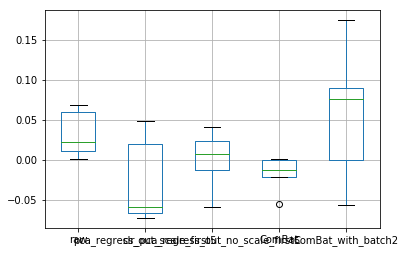

In [10]:
df_pearson = pd.DataFrame()
#df_pearson['raw'] = pd.Series(all_methods_stats['raw']['pearson'])
df_pearson['raw'] = pd.Series(all_methods_stats['raw']['pearson'])
#df_pearson['bmc'] = pd.Series(all_methods_stats['bmc']['pearson'])
#df_pearson['pca_regress_out_scale_first2'] = pd.Series(all_methods_stats['pca_regress_out_scale_first2']['pearson'])
#df_pearson['clr_pca_regress_out_no_scale_first2'] = pd.Series(all_methods_stats['clr_pca_regress_out_no_scale_first2']['pearson'])

df_pearson['pca_regress_out_scale_first5'] = pd.Series(all_methods_stats['pca_regress_out_scale_first5']['pearson'])
df_pearson['clr_pca_regress_out_no_scale_first5'] = pd.Series(all_methods_stats['clr_pca_regress_out_no_scale_first5']['pearson'])
df_pearson['ComBat'] = pd.Series(all_methods_stats['ComBat']['pearson'])
df_pearson['ComBat_with_batch2'] = pd.Series(all_methods_stats['ComBat_with_batch2']['pearson'])


#df_pearson['pca'] = pd.Series(all_methods_stats['pca_regress_out_scale_first1']['pearson'])
#df_pearson['clr_pca'] = pd.Series(all_methods_stats['clr_pca_regress_out_scale_first1']['pearson'])
#df_pearson['clr_pca_no_scale'] = pd.Series(all_methods_stats['clr_pca_regress_out_no_scale_first1']['pearson'])

boxplot = df_pearson.boxplot()
#boxplot.xticks(rotation=90)

In [26]:
 df_pearson.columns

Index(['raw', 'bmc', 'pca_regress_out_scale_first2',
       'clr_pca_regress_out_no_scale_first2', 'pca_regress_out_scale_first5',
       'clr_pca_regress_out_no_scale_first5', 'ComBat', 'ComBat_with_batch2'],
      dtype='object')

Text(0.5,1,'Pearson')

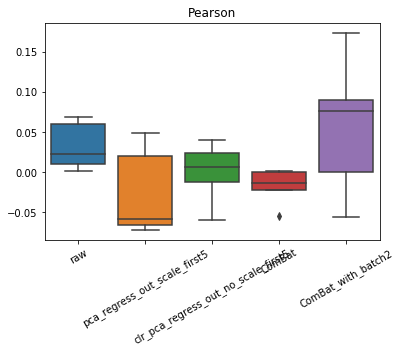

In [11]:
import seaborn as sns

 
# Make boxplot for one group only
g=sns.boxplot( data = df_pearson)
g.set_xticklabels(rotation=30,labels = df_pearson.columns)
g.set_title('Pearson')

Text(0.5,1,'Pearson')

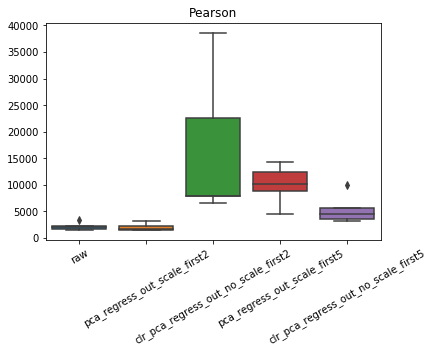

In [24]:
g=sns.boxplot( data = df_mse.transpose())
g.set_xticklabels(rotation=30,labels = df_mse.columns)
g.set_title('Pearson')

In [53]:
auc_fix = False
for n in names:
    print(n)
    for method in methods:
        print(method)
        if auc_fix:
            print(1-np.mean(all_methods_auc_stats[method][n]['auc_all']))
        else: 
            print(np.mean(all_methods_auc_stats[method][n]['auc_all']))
        

Random Forest
rel_ab
0.5532537771218303
ComBat
0.5704458318082963
slope_correction
0.5523683348393076
limma
0.5962790943363393
bmc
0.512867155216362
clr_pca_out
0.5318368550114623
Naive Bayes
rel_ab
0.5432446953221123
ComBat
0.5441700881280771
slope_correction
0.5113533934252384
limma
0.5380644568812121
bmc
0.5558969888212063
clr_pca_out
0.6100864604081326


In [51]:
y_scores


array(['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 

/Users/leahbriscoe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Users/leahbriscoe/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


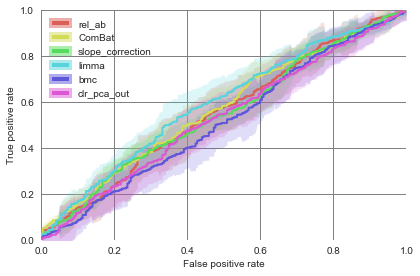

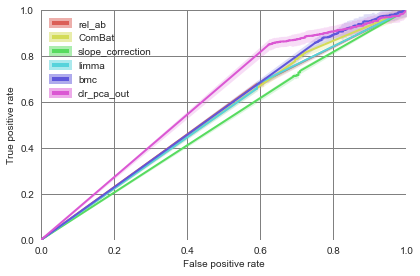

In [54]:
for name in names:    
    text_size = 10
    title = 'ROC curves'
    x_label = 'False positive rate'
    y_label = 'True positive rate'



    nplots=1
    plot_par_factor=2.26
    runs_cv_folds = 10
    plot_alpha=0.2
    fig, ax = plt.subplots(nplots, sharex=True, sharey=True)
    import seaborn as sns
    sns.set()
    current_palette = sns.color_palette()
    #sns.palplot(current_palette)
    palette = sns.color_palette("hls", len(methods))
    plot_color = palette.as_hex()
    plot_marker = ['None','None']
    plot_ls = ['-','--']
    plot_lw = 2
    plot_title = "test"

    for i in range(0,len(methods)):
        #'Naive Bayes''Random Forest'
        if auc_fix:
            fpr_all = 1- np.array(all_methods_auc_stats[methods[i]][name]['fpr_all'])
            tpr_i = 1- np.array(all_methods_auc_stats[methods[i]][name]['tpr_i'])
            tpr_all = 1-np.array(all_methods_auc_stats[methods[i]][name]['tpr_all'])
        else:
            fpr_all = all_methods_auc_stats[methods[i]][name]['fpr_all']
            tpr_i = all_methods_auc_stats[methods[i]][name]['tpr_i']
            tpr_all = all_methods_auc_stats[methods[i]][name]['tpr_all']

        ax.fill_between(fpr_all, tpr_all-np.std(tpr_i, axis=0)*plot_par_factor/np.sqrt(runs_cv_folds), tpr_all+np.std(tpr_i, axis=0)*plot_par_factor/np.sqrt(runs_cv_folds), color=plot_color[i], lw=0, alpha=plot_alpha)
        ax.plot(fpr_all, tpr_all, color=plot_color[i], ls='-', lw=plot_lw, marker=plot_marker[0])

    # fig.subplots_adjust(hspace=0)
    ax.set_xlabel(x_label, size=text_size)
    ax.tick_params(labelsize=text_size, axis='x')
    ax.set_ylabel(y_label, size=text_size)
    ax.tick_params(labelsize=text_size, axis='y')
    #ax.text(plot_title,plot_title,plot_title, va='center', ha='center', size=text_size+2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    # ax.set_yticklabels(ax.get_yticks()[:-1])
    # ax.set_title(title, size=text_size+2)
    #leg = ax.legend()
    #leg_col = [plt.Rectangle((0, 0), 1, 1, fc=s, linewidth=0) for s in plot_color] + [plt.Line2D([0,1], [0,1], c='k', ls='-', lw=2)] + [plt.Line2D([0,1], [0,1], c='k', ls='--', lw=2)]
    #leg = ax.legend(leg_col, prop={'size':text_size}, loc='center left', bbox_to_anchor=(1.02,1), numpoints=1)
    #leg.get_frame().set_alpha(0)

    class LegendObject(object):
        def __init__(self, facecolor='white', edgecolor='white', dashed=False):
            self.facecolor = facecolor
            self.edgecolor = edgecolor
            self.dashed = dashed

        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            x0, y0 = handlebox.xdescent, handlebox.ydescent
            width, height = handlebox.width, handlebox.height
            patch = mpatches.Rectangle(
                # create a rectangle that is filled with color
                [x0, y0], width, height, facecolor=self.facecolor,
                # and whose edges are the faded color
                edgecolor=self.edgecolor, lw=3)
            handlebox.add_artist(patch)

            # if we're creating the legend for a dashed line,
            # manually add the dash in to our rectangle
            if self.dashed:
                patch1 = mpatches.Rectangle(
                    [x0 + 2*width/5, y0], width/5, height, facecolor=self.edgecolor,
                    transform=handlebox.get_transform())
                handlebox.add_artist(patch1)

            return patch

    from matplotlib.colors import colorConverter as cc
    import matplotlib.patches as mpatches
    bg = np.array([1, 1, 1])  # background of the legend is white
    colors = plot_color
    # with alpha = .5, the faded color is the average of the background and color
    colors_faded = [(np.array(cc.to_rgb(color)) + bg) / 2.0 for color in colors]

    ax.legend(list(range(6)), methods[0:6],
               handler_map={
                   0: LegendObject(colors[0], colors_faded[0]),
                   1: LegendObject(colors[1], colors_faded[1]),
                   2: LegendObject(colors[2], colors_faded[2]),
                   3: LegendObject(colors[3], colors_faded[3]),
                   4: LegendObject(colors[4], colors_faded[4]),
                   5: LegendObject(colors[5], colors_faded[5])
                })
    ax.set_facecolor('white')
    #ax.title('AUC confidence interval plot')
    fig.tight_layout()
    #fig.set_axis_on()
    ax.grid(color = "grey")
    fig.show()


    fig.savefig(str(plot_folder) + '/AUC_' + str(name) + str('.pdf'))


In [17]:
plot_folder

'/Users/leahbriscoe/Documents/MicroBatch/MicrobiomeDenoisingData/WR_AD'

In [32]:
fpr_all = 1-np.array(all_methods_auc_stats[methods[i]]['Naive Bayes']['fpr_all'])

In [33]:
fpr_all

array([1.        , 0.30909091, 0.30909091, 0.30909091, 0.30909091,
       0.30909091, 0.30863636, 0.30863636, 0.30818182, 0.30818182,
       0.30772727, 0.30772727, 0.30727273, 0.30727273, 0.30681818,
       0.30681818, 0.30636364, 0.30636364, 0.30590909, 0.30590909,
       0.30545455, 0.30545455, 0.305     , 0.305     , 0.30454545,
       0.30454545, 0.30409091, 0.30409091, 0.30363636, 0.30363636,
       0.30318182, 0.30318182, 0.30272727, 0.30272727, 0.30227273,
       0.30227273, 0.30181818, 0.30181818, 0.30136364, 0.30136364,
       0.30090909, 0.30090909, 0.30045455, 0.30045455, 0.3       ,
       0.3       , 0.29909091, 0.29909091, 0.29863636, 0.29863636,
       0.29818182, 0.29818182, 0.29772727, 0.29772727, 0.29727273,
       0.29727273, 0.29681818, 0.29681818, 0.29636364, 0.29636364,
       0.29590909, 0.29590909, 0.29545455, 0.29545455, 0.295     ,
       0.295     , 0.29454545, 0.29454545, 0.29409091, 0.29409091,
       0.29363636, 0.29363636, 0.29318182, 0.29318182, 0.29272